# Predicting Subscription Status Based on Experience Level, Age, and Hours Played 

#### Anthony Lu, Ashley Lee, and Guneet Kaur

In [164]:
library(tidyverse)
library(janitor)
library(tidymodels)

### Introduction

#### Broad Question
* What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

#### Specific Question
* Can experience level, hours played, and age predict whether or not a player is subscribed to a game-related newsletter?

#### Relevant Dataset
* players.csv. Let's read it in!

In [165]:
players_url <- "https://raw.githubusercontent.com/anthonyl8/video_game_server_usage/refs/heads/main/players.csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Tidying the Data

Below, I've tidied the data by cleaning the column names, mutating character variable columns to become factor variable columns, and removing the two players with ages recorded as N/A. 



In [166]:
players <- players |>
    clean_names() |>
    mutate(experience = as_factor(experience), gender = as_factor(gender)) |>
    drop_na()

---
### Description of Tidied Data
* **Rows/Observations**: 194 (each represents a player)
* **Columns/Variables**: 7

**Categorical Variables:**
* experience (character): player's experience level on a scale of 5 categories
* subscribe (logical): whether a player is subscribed to a game-related newsletter or not
* hashed_email (character): player's email address in a hashed format
* name (character): player's first name
* gender (character): player's gender
  
**Quantitative Variables:**
* played_hours (double): number of hours played by player
* age (double): player's age
---

**Notes:**
* For our question, we'll need to mutate the values in the experience column to integers from 1 to 5. We are not given an ordering for the categories for experience level, but this report *assumes* the following order by skill level: Beginner, Amateur, Regular, Pro, Veteran. Thus, the values in the experience column will be mutated to become integers from 1 to 5, where 1 = Beginner and 5 = Veteran.
* Because subscribe is the response variable, it will also need to be mutated to become a factor variable.

This additional wrangling is handled below.

In [167]:
players <- players |>
    mutate(experience = as.integer(fct_recode(experience, "1" = "Beginner", "2" = "Amateur", "3" = "Regular", "4" = "Pro", "5" = "Veteran")), 
           subscribe = as_factor(subscribe))

Now, let's look at some summary statistics!

### Summary Statistics
* Mean and standard deviation for our explanatory variables (**hours_played**, **age**, and **experience**), which are quantitative
* Categorical frequencies for our response variable (**subscribe**), which is categorical

#### Hours Played:

In [168]:
players_summary_hours_played <- players |>
    summarize(avg_played_hours = mean(played_hours),
              sd_played_hours = sd(played_hours))
players_summary_hours_played

avg_played_hours,sd_played_hours
<dbl>,<dbl>
5.904639,28.49793


#### Age:

In [169]:
players_summary_age <- players |>
    summarize(avg_age = mean(age),
              sd_age = sd(age))
players_summary_age

avg_age,sd_age
<dbl>,<dbl>
20.52062,6.174667


#### Experience:

In [170]:
players_experience <- players |>
    count(experience) |>
    mutate(num_players = n) |>
    select(-n)
players_experience

experience,num_players
<int>,<int>
1,13
2,48
3,63
4,35
5,35


#### Subscribe:

In [171]:
players_subscribe <- players |>
    count(subscribe) |>
    mutate(num_players = n) |>
    select(-n)
players_subscribe

subscribe,num_players
<fct>,<int>
FALSE,52
TRUE,142


#### Gender:

In [172]:
players_gender <- players |>
    count(gender) |>
    mutate(num_players = n) |>
    select(-n)
players_gender

gender,num_players
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Agender,2
Two-Spirited,5


---
### Visualizations and Conclusions

Here are three visualizations, each of which compares one explanatory variable to the response variable (subscription status).

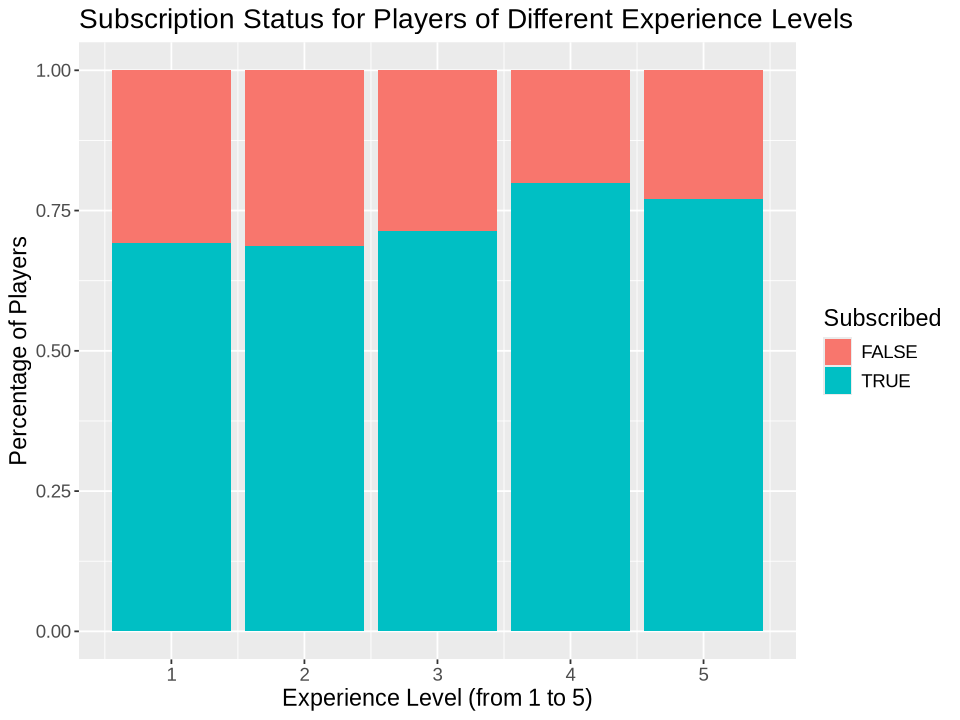

In [173]:
options(repr.plot.width = 8, repr.plot.height = 6)
players_experience_plot <- players |>
    ggplot(aes(x = experience)) +
    geom_bar(stat = "count", position = "fill", aes(fill = subscribe)) +
    xlab("Experience Level (from 1 to 5)") +
    ylab("Percentage of Players") +
    ggtitle("Subscription Status for Players of Different Experience Levels") +
    labs(fill = "Subscribed") +
    theme(text = element_text(size = 14))
players_experience_plot

#### Figure 1: Segmented bar chart showing relative frequencies of players' subscription statuses for each experience level

**Conclusion:** *Maybe* more experienced players are more likely to be subscribed?

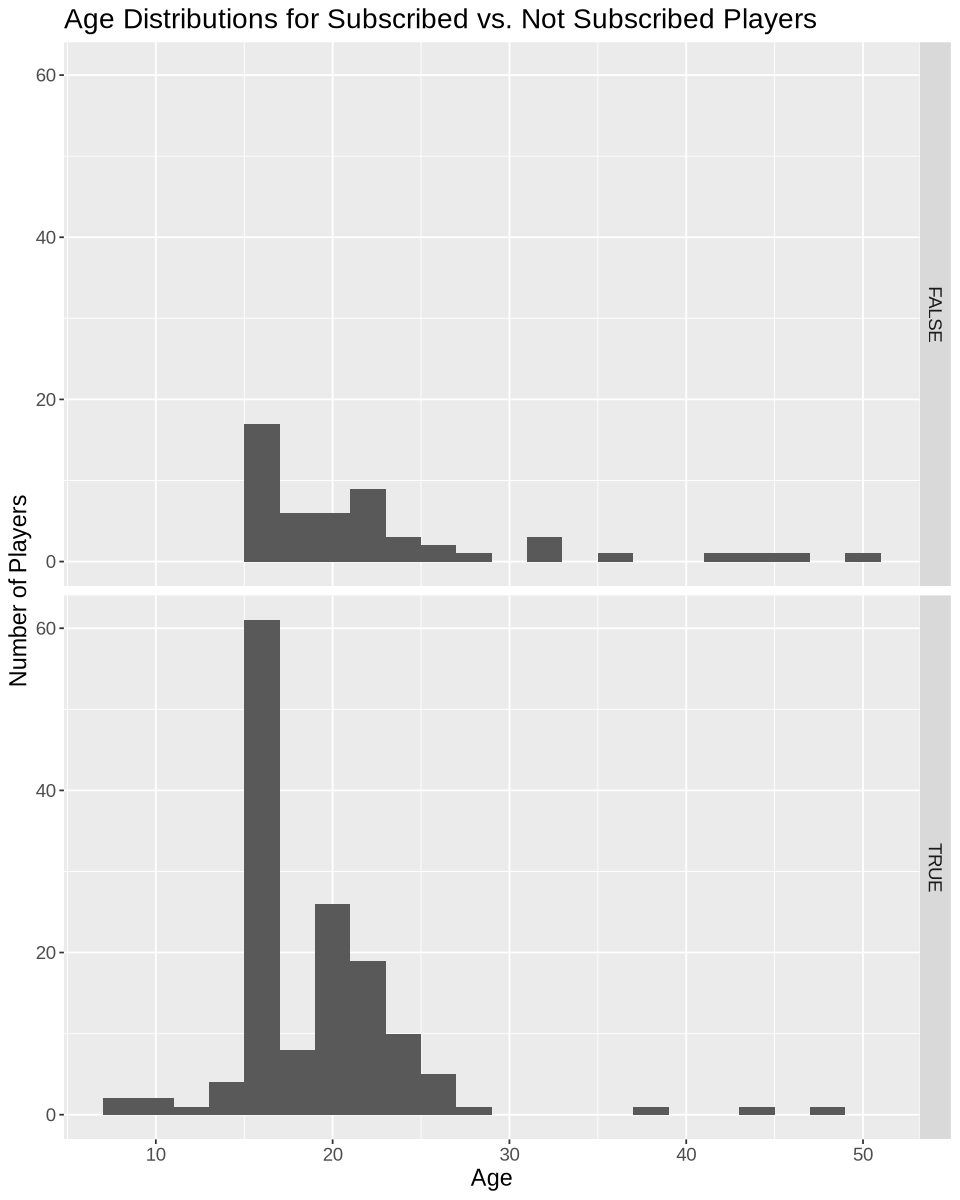

In [174]:
options(repr.plot.height = 10, repr.plot.width = 8)
players_age_plot <- players |>
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 2) +
    facet_grid(rows = vars(subscribe)) +
    xlab("Age") +
    ylab("Number of Players") +
    ggtitle("Age Distributions for Subscribed vs. Not Subscribed Players") +
    theme(text = element_text(size = 14))
players_age_plot

#### Figure 2: Two histograms showing distributions of player ages for each subscription status

**Conclusion:** *Maybe* subscribed players are a bit more likely to be younger?

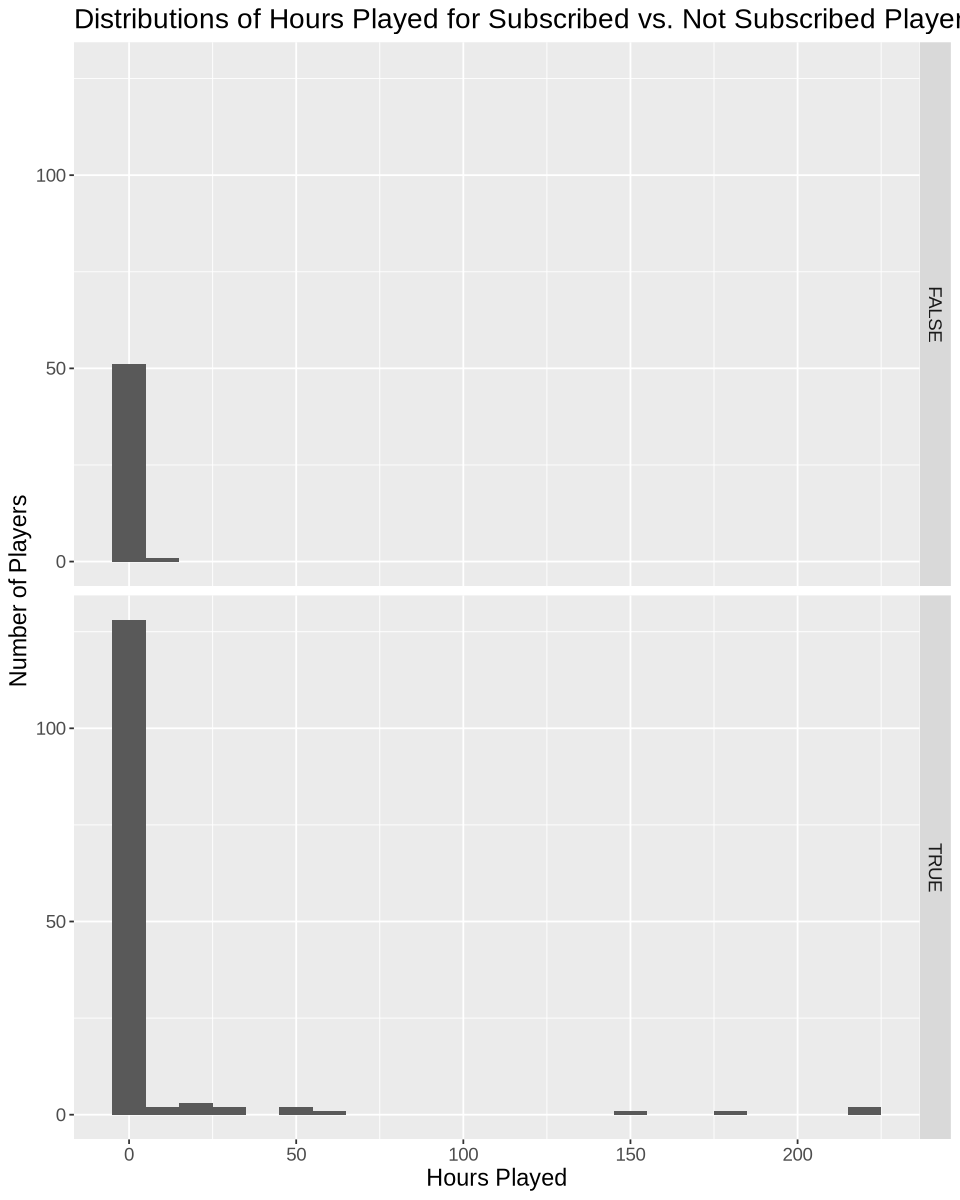

In [175]:
options(repr.plot.height = 10, repr.plot.width = 8)
players_played_hours_plot <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 10) +
    facet_grid(rows = vars(subscribe)) +
    xlab("Hours Played") +
    ylab("Number of Players") +
    ggtitle("Distributions of Hours Played for Subscribed vs. Not Subscribed Players") +
    theme(text = element_text(size = 14))
players_played_hours_plot

#### Figure 3: Two histograms showing distributions of hours played for each subscription status

**Conclusion**: It seems like players who've played for way more hours than most others are all subscribed.

All 3 predictor variables seem like they could affect subscription status, which validates the specific question posed by this report. However, all observed relationships also do not seem very strong, so further investigation will be necessary in order to draw more specific conclusions.

### Addressing the Question

This report will use k nearest neighbours classification, which is appropriate because I'm predicting a categorical variable using 3 quantitative predictor variables. This method requires few assumptions, which is good, but it may be sensitive to outliers.

Let's split the data into training and testing sets (at a 75/25 ratio) and stratify by subscription status.

In [176]:
set.seed(3456)

players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)
head(players_train)
head(players_test)

experience,subscribe,hashed_email,played_hours,name,gender,age
<int>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
2,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
3,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
3,FALSE,2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53,0.0,Quinlan,Male,22
2,FALSE,f8acd26a5e452b682b9f8b20108caef1ee2e745efe08e95806980bd2388a3fea,0.0,Finn,Male,23
2,FALSE,951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd,0.1,Vivienne,Male,18
3,FALSE,df6a1201c9c638aff1df8aeaf459a5b0a00aa04824936ee0305f5c275352c647,0.0,Vasco,Prefer not to say,33


experience,subscribe,hashed_email,played_hours,name,gender,age
<int>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>
3,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
4,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
3,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
3,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17
1,TRUE,4caa42e1b20511552434978171dcf7283fb6eb857eb871327e39bfc328002309,0.0,Daniela,Male,17
3,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,Female,17


Let's create a recipe that uses experience, played_hours, and age as predictors, and scales and centers these predictors. Let's also make a model specification that tunes on the number of neighbours.

In [177]:
knn_tune <- nearest_neighbor(weight = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_tune
players_recipe <- recipe(subscribe ~ experience + played_hours + age, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())
players_recipe

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



Next, we'll perform a 5-fold cross-validation on the training set to determine the optimal k, creating a workflow analysis with the recipe and model specifications from above and trying k = 1 to 50.

In [178]:
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals)

Now, we'll collect the metrics from our workflow analysis and filter the metrics by accuracy.

In [179]:
knn_metrics <- knn_results |>
    collect_metrics()
accuracies <- knn_metrics |> 
      filter(.metric == "accuracy")

Let's visualize the accuracy as k increases.

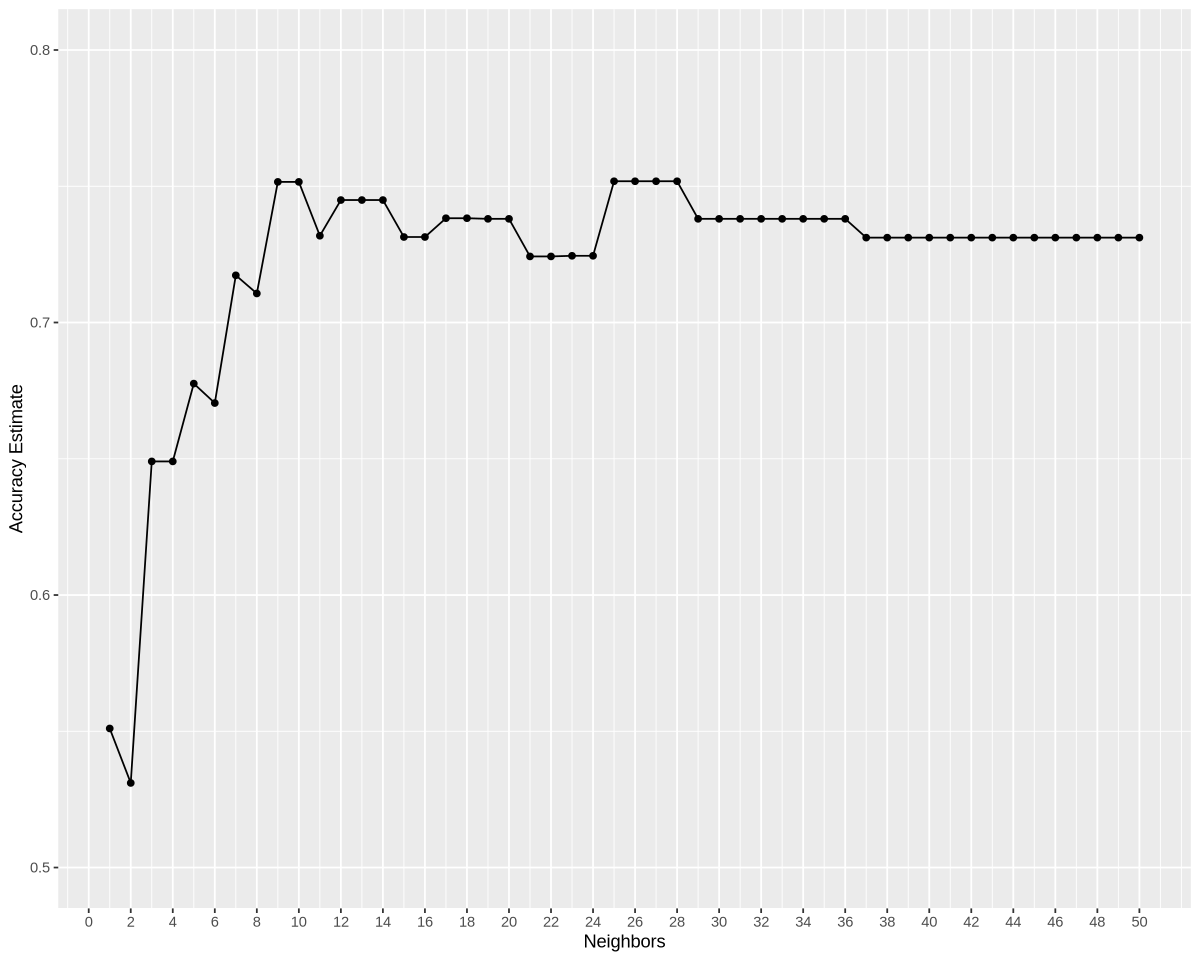

In [183]:
options(repr.plot.width = 10, repr.plot.height = 8)
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 50, by = 2)) +
      scale_y_continuous(limits = c(0.5, 0.8))
accuracy_versus_k

#### Figure 4: Accuracy Estimate for Increasing Number of Neighbours

From Figure 4, it appears that k = 25 to 28 neighbours will give us the highest accuracy. We'll use k = 25 to create our final model.

Let's first create our model specification with our chosen optimal k (25).

In [184]:
knn_final_spec <- nearest_neighbor(weight = "rectangular", neighbors = 25) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_final_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 25
  weight_func = rectangular

Computational engine: kknn 


Now, let's create a workflow analysis using our new model specification, reusing the previous recipe specification, and passing in our training dataset.

In [187]:
knn_final_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_final_spec) |>
    fit(data = players_train)
knn_final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(25,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2482759
Best kernel: rectangular
Best k: 25

Next, we'll use this final model to make predictions on the testing dataset. Then, we'll determine the accuracy of these predictions and also show the confusion matrix.

In [189]:
knn_final_predictions <- predict(knn_final_fit, players_test) |>
    bind_cols(players_test)

knn_final_metrics <- knn_final_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

knn_final_conf_mat <- knn_final_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

knn_final_metrics
knn_final_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


          Truth
Prediction FALSE TRUE
     FALSE     1    2
     TRUE     12   34